Using device: cuda
Loading best model from checkpoints/best_model.pth
Best accuracy: 94.62%
Plotting training metrics...


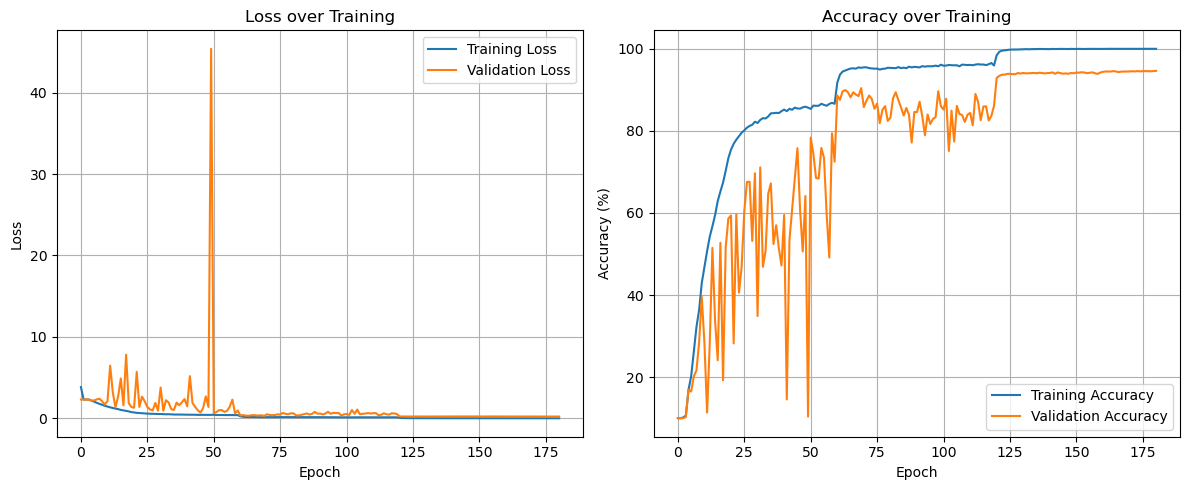

Evaluating model...
Overall Test Accuracy: 94.62%


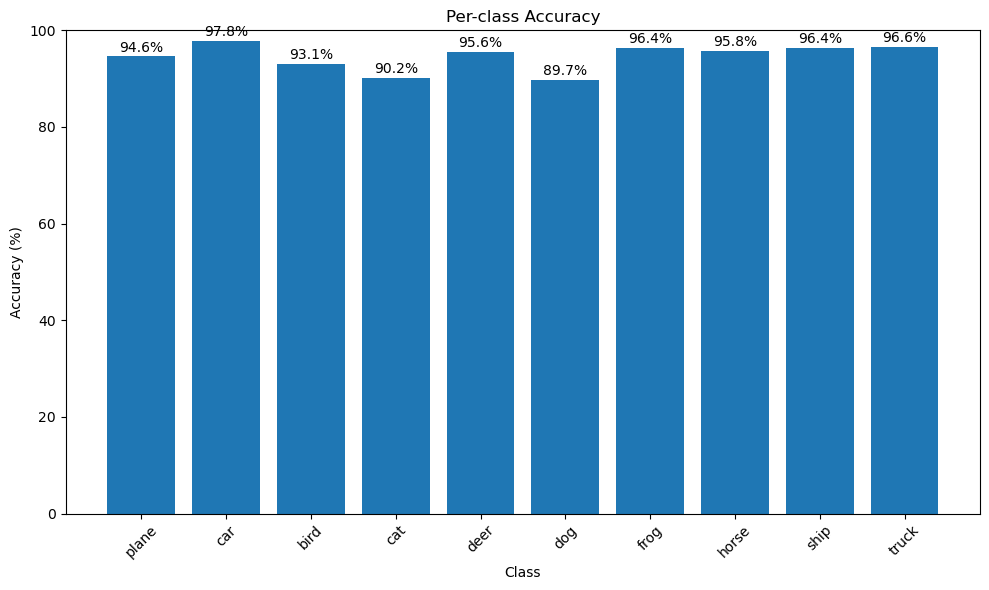

Visualizing predictions...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.704840

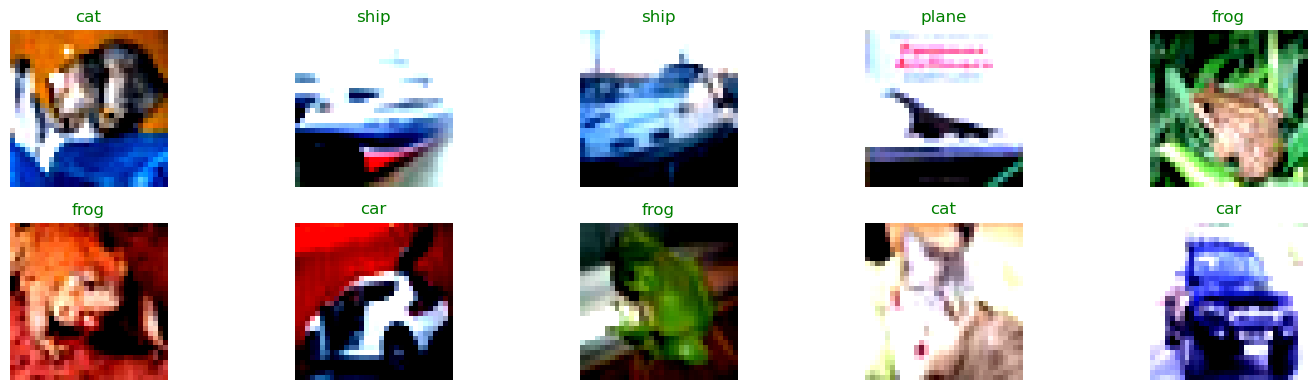

Creating confusion matrix...
[[946   2   9  10   0   1   4   2  22   4]
 [  1 978   0   1   0   0   0   0   2  18]
 [ 15   0 931  18   8  13  11   3   1   0]
 [  4   3  12 902  11  55   6   3   2   2]
 [  2   0  17   9 956   6   6   4   0   0]
 [  3   2   9  64  14 897   3   8   0   0]
 [  2   0  12  16   3   0 964   2   0   1]
 [  3   0   5  10   9  12   2 958   1   0]
 [ 18   3   4   3   0   0   0   0 964   8]
 [  5  21   1   2   0   0   0   0   5 966]]


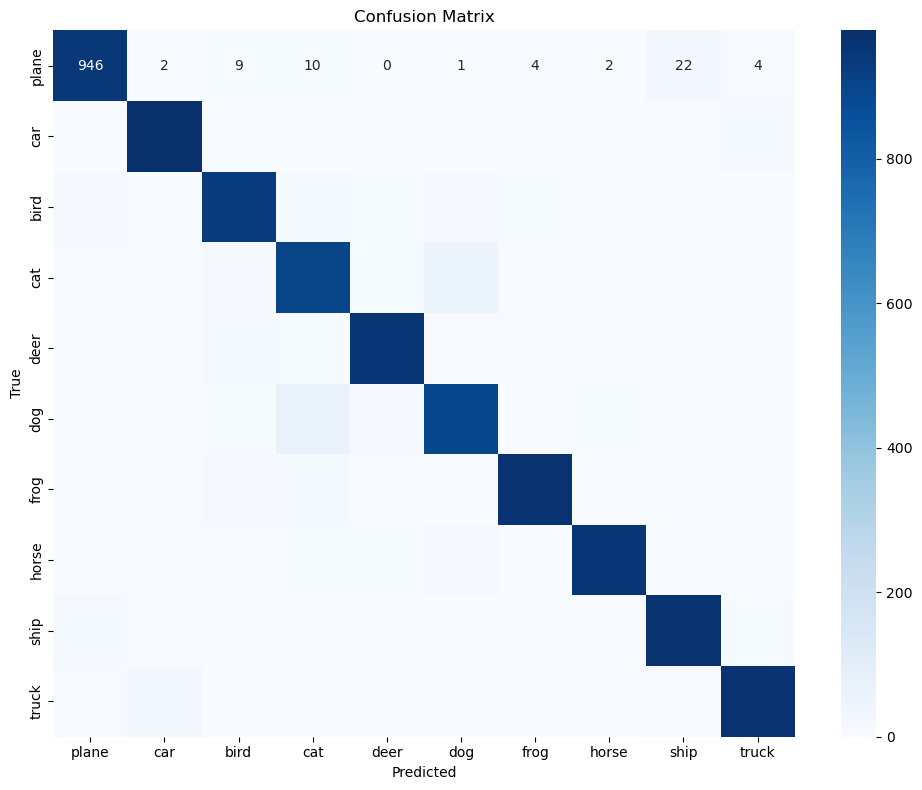

Visualization complete!


In [7]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import time
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model architecture (copied from train_hpc.py)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        inplanes, planes = int(inplanes), int(planes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ModelNet(nn.Module):
    def __init__(self, depth=26, alpha=48, num_classes=10):
        super(ModelNet, self).__init__()
        self.inplanes = 16
    
        n = (depth - 2) // 6
        block = BasicBlock
            
        self.addrate = alpha / (3 * n * 1.0)
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        
        # Layers
        self.layer1 = self._make_layer(block, n, stride=1)
        
        # Transition layers to handle channel changes
        layer1_planes = self.inplanes
        self.trans1 = nn.Sequential(
            nn.Conv2d(16, int(layer1_planes), kernel_size=1, bias=False),
            nn.BatchNorm2d(int(layer1_planes))
        )
        
        self.layer2 = self._make_layer(block, n, stride=2)
        
        layer2_planes = self.inplanes
        self.trans2 = nn.Sequential(
            nn.Conv2d(int(layer1_planes), int(layer2_planes), kernel_size=1, bias=False),
            nn.BatchNorm2d(int(layer2_planes))
        )
        
        self.layer3 = self._make_layer(block, n, stride=2)
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Determine feature size dynamically with a dummy forward pass
        dummy_input = torch.zeros(1, 3, 32, 32)  # CIFAR image size
        with torch.no_grad():
            dummy_output = self._forward_features(dummy_input)
            feature_size = dummy_output.size(1)
        
        # Classifier with dynamically determined feature size
        self.fc = nn.Linear(feature_size, num_classes)
        
        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def _make_layer(self, block, blocks, stride):
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.AvgPool2d(stride, stride, ceil_mode=True),
            )
            
        layers = []
        
        # Store the starting number of planes for this layer
        current_planes = int(self.inplanes)
        
        # Create all blocks with the same number of planes
        for i in range(blocks):
            if i == 0:
                layers.append(block(current_planes, current_planes, stride, downsample))
            else:
                layers.append(block(current_planes, current_planes))
        
        # Update planes for the next layer (all at once, after the layer is complete)
        self.inplanes += blocks * self.addrate
                
        return nn.Sequential(*layers)
    
    def _forward_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.trans1(x)
        
        x = self.layer2(x)
        x = self.trans2(x)
        
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x
        
    def forward(self, x):
        x = self._forward_features(x)
        x = self.fc(x)
        return x

# Define the test data loader (without loading train data)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Only load the testing set 
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

# Define classes in CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Path to checkpoint directory
checkpoint_dir = 'checkpoints'

# Find the best checkpoint
def find_best_checkpoint():
    best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
    final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')
    
    if os.path.exists(best_model_path):
        return best_model_path, "best model"
    elif os.path.exists(final_model_path):
        return final_model_path, "final model"
    else:
        # Find any checkpoint file
        available_checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
        if available_checkpoints:
            return os.path.join(checkpoint_dir, available_checkpoints[0]), f"checkpoint {available_checkpoints[0]}"
        else:
            return None, None

# Load the model checkpoint
checkpoint_path, checkpoint_type = find_best_checkpoint()
if checkpoint_path is None:
    raise FileNotFoundError("No checkpoints found in directory")

print(f"Loading {checkpoint_type} from {checkpoint_path}")
checkpoint = torch.load(checkpoint_path)

# Extract training history
train_losses = checkpoint.get('train_losses', [])
train_accs = checkpoint.get('train_accs', [])
test_losses = checkpoint.get('test_losses', [])
test_accs = checkpoint.get('test_accs', [])
best_acc = checkpoint.get('best_acc', 0)

# Create the model and load state
depth = 110  # Use the same depth as during training
alpha = 270  # Use the same alpha as during training
model = ModelNet(depth=depth, alpha=alpha, num_classes=10).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode

print(f"Best accuracy: {best_acc:.2f}%")

# Function to plot metrics
def plot_training_metrics():
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Training')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(test_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Training')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png',dpi=600)
    plt.show()

# Function to evaluate model performance
def evaluate_model():
    model.eval()
    total = 0
    correct = 0
    class_correct = [0] * 10
    class_total = [0] * 10
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate per-class accuracy
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1
    
    # Calculate overall accuracy
    overall_accuracy = 100 * correct / total
    
    # Calculate per-class accuracy
    class_accuracy = {}
    for i in range(10):
        if class_total[i] > 0:
            class_accuracy[classes[i]] = 100 * class_correct[i] / class_total[i]
    
    # Print results
    print(f"Overall Test Accuracy: {overall_accuracy:.2f}%")
    
    # Plot per-class accuracy
    plt.figure(figsize=(10, 6))
    classes_list = list(class_accuracy.keys())
    accuracy_list = list(class_accuracy.values())

    plt.bar(classes_list, accuracy_list)
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    
    for i, v in enumerate(accuracy_list):
        plt.text(i, v + 1, f"{v:.1f}%", ha='center')
    
    plt.tight_layout()
    plt.savefig('class_accuracy.png',dpi=600)
    plt.show()
    
    return overall_accuracy, class_accuracy

# Function to visualize predictions
def visualize_predictions():
    # Function to show an image
    def imshow(img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')

    # Get a batch of test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Move to device
    images = images.to(device)
    labels = labels.to(device)

    # Get model predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Show images and predictions (first 10)
    plt.figure(figsize=(15, 4))
    num_images = min(10, images.size(0))

    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        imshow(images[i])
        color = "green" if predicted[i] == labels[i] else "red"
        plt.title(f"{classes[predicted[i]]}", color=color)

    plt.tight_layout()
    plt.savefig('predictions.png',dpi=600)
    plt.show()

# Function to create confusion matrix
def plot_confusion_matrix():
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png',dpi=600)
    plt.show()

# Run all visualization functions
if __name__ == "__main__":
    print("Plotting training metrics...")
    plot_training_metrics()
    
    print("Evaluating model...")
    evaluate_model()
    
    print("Visualizing predictions...")
    visualize_predictions()
    
    print("Creating confusion matrix...")
    plot_confusion_matrix()
    
    print("Visualization complete!")